# Bundle Selection

Identify a loop visually in the AIA images and find the field lines that most closely correspond to that visually-identified loop.

In [58]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pydrad.configure
import pydrad.configure.data
import shapely
import shapely.plotting
import sunpy.map
import synthesizAR

from astropy.coordinates import SkyCoord
from greensfield.util import (find_fieldlines_intersecting_loop,
                              find_fieldlines_within_loop_footprint,
                              _coordinate_to_linestring)
from synthesizAR.interfaces.hydrad import HYDRADInterface
from synthesizAR.models import semi_circular_loop


In [21]:
skeleton = synthesizAR.Skeleton.from_asdf('data/bare_skeleton.asdf')

In [3]:
aia_maps = sunpy.map.Map('data/AIA/aia.lev1.*.image_lev1.fits')

In [4]:
bottom_left = SkyCoord(Tx=-175*u.arcsec,Ty=-225*u.arcsec,frame=aia_maps[1].coordinate_frame)
top_right = SkyCoord(Tx=150*u.arcsec,Ty=125*u.arcsec,frame=aia_maps[1].coordinate_frame)

In [5]:
aia_maps = [m.submap(bottom_left, top_right=top_right) for m in aia_maps]

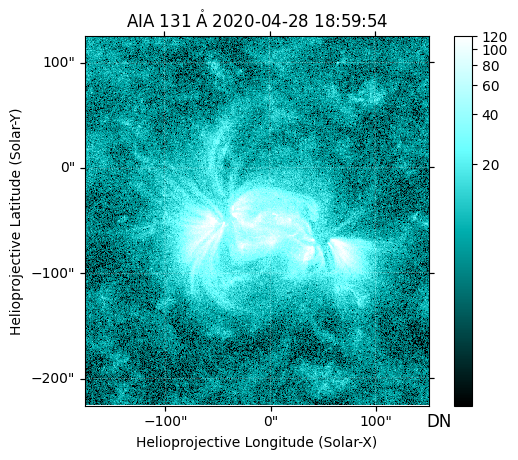

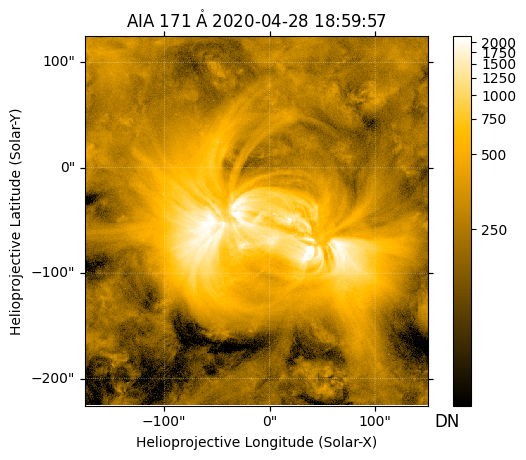

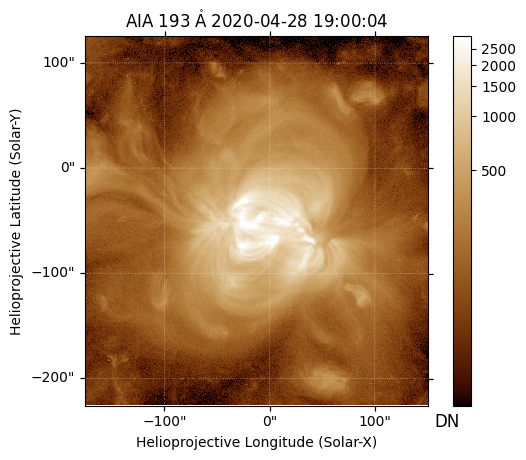

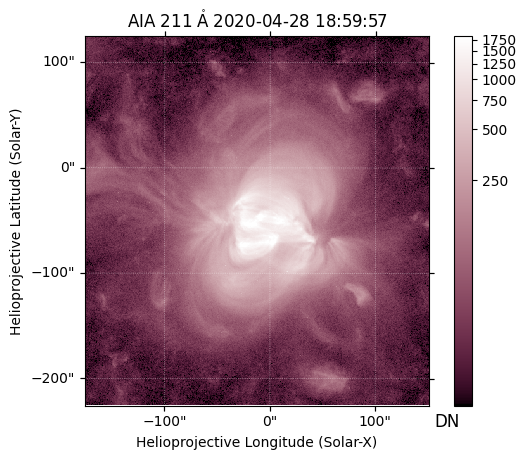

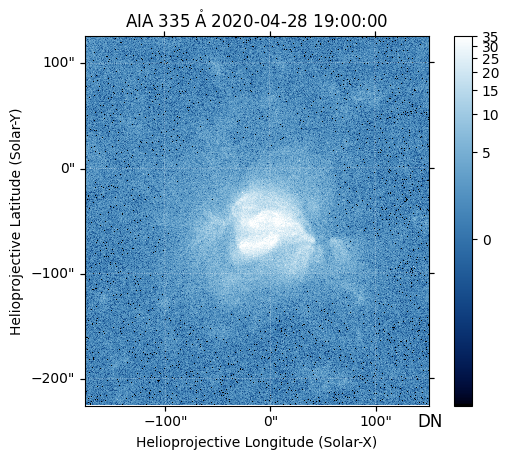

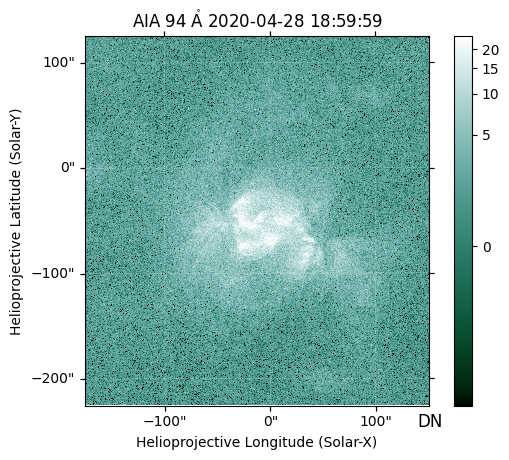

In [6]:
for m in aia_maps:
    m.peek(clip_interval=(1,99.9)*u.percent)

Try defining a semi-circular loop that corresponds approximately to a bright feature as seen by AIA 171 Å.

In [7]:
orientation = aia_maps[1].center.transform_to('heliographic_stonyhurst')
orientation = SkyCoord(
    lon=0.5*u.deg,#orientation.lon+5*u.deg,
    lat=-7*u.deg,#orientation.lat-5*u.deg,
    radius=orientation.radius,
    frame=orientation.frame,
)
visual_loop = semi_circular_loop(100*u.Mm,
                                 observer=orientation,
                                 gamma=-27*u.deg,
                                 #offset=[15,0]*u.Mm,
                                 inclination=30*u.deg,
                                 ellipticity=0.9)

In [16]:
width = 10
loop_polygon = _coordinate_to_linestring(
    visual_loop,
    aia_maps[1].wcs,
).buffer(
    width,
    cap_style='flat',
)

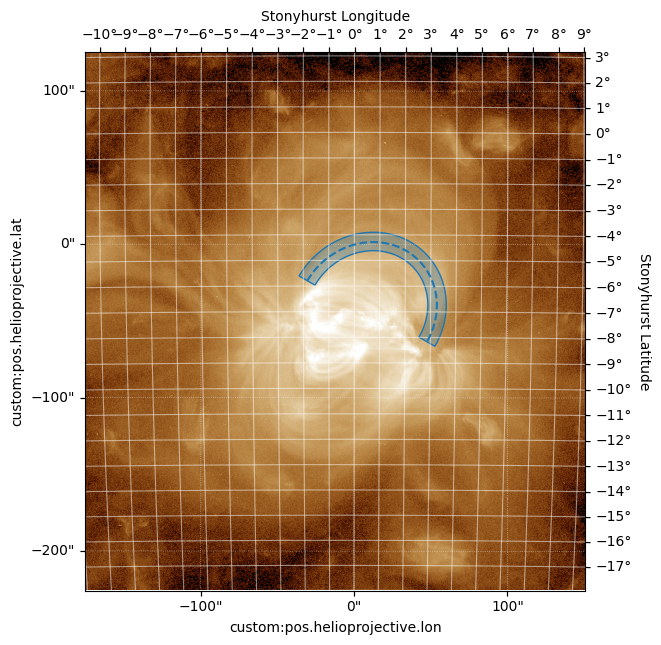

In [19]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=aia_maps[2])
aia_maps[2].plot(axes=ax, clip_interval=(1,99.9)*u.percent, annotate=False)
ax.plot_coord(visual_loop, color='C0', ls='--')
m.draw_grid(axes=ax, grid_spacing=1*u.deg);
shapely.plotting.plot_polygon(loop_polygon,ax=ax,add_points=False)

In [22]:
overlap_strands = find_fieldlines_intersecting_loop(
    skeleton.strands,
    visual_loop,
    aia_maps[1].wcs,
    width=width,
)

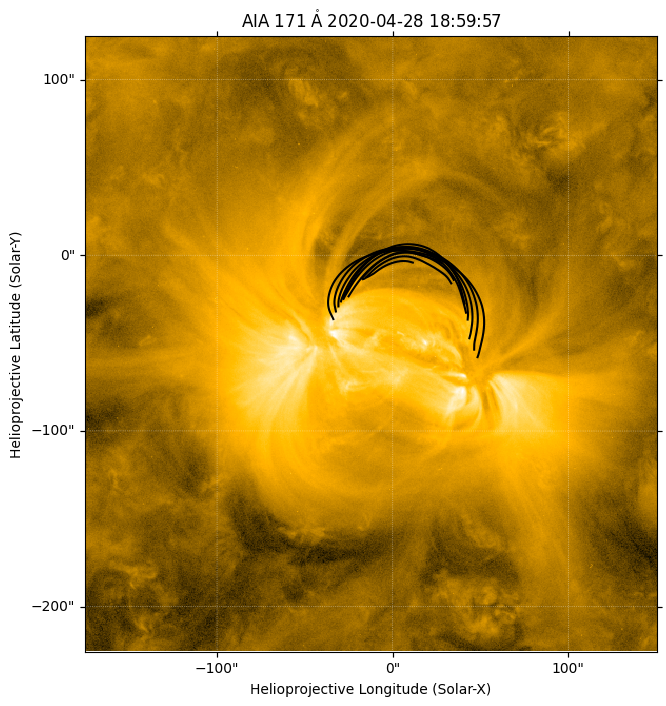

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=aia_maps[1])
aia_maps[1].plot(axes=ax)
for f in overlap_strands:
    ax.plot_coord(f.coordinate, color='k')

This is not really that convincing as the resulting fieldlines don't look like they correspond visually to any feature in the image. Let's instead try to group these by where they connect at the surface. We define the loop "footprint" by the center of the bright point corresponding to the footpoints of the loop bundle and some radius (in pixel space).

In [32]:
radius = 5
footprint_center = SkyCoord(Tx=-45*u.arcsec,
                            Ty=-55*u.arcsec,
                            frame=aia_maps[1].coordinate_frame)
footprint = shapely.geometry.Point(aia_maps[1].wcs.world_to_pixel(footprint_center)).buffer(radius)

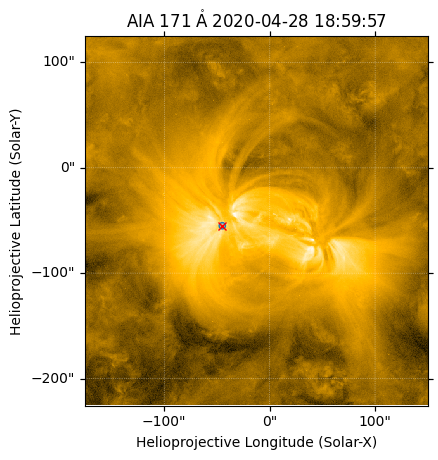

In [33]:
fig = plt.figure()
ax = fig.add_subplot(projection=aia_maps[1])
aia_maps[1].plot(axes=ax)
ax.plot_coord(footprint_center, color='r', marker='x', ls='', )
shapely.plotting.plot_polygon(footprint, ax=ax, add_points=False)

In [34]:
bundle_strands = find_fieldlines_within_loop_footprint(skeleton.strands,
                                                       footprint_center,
                                                       aia_maps[1].wcs,
                                                       radius=radius,
                                                       index=-1,)

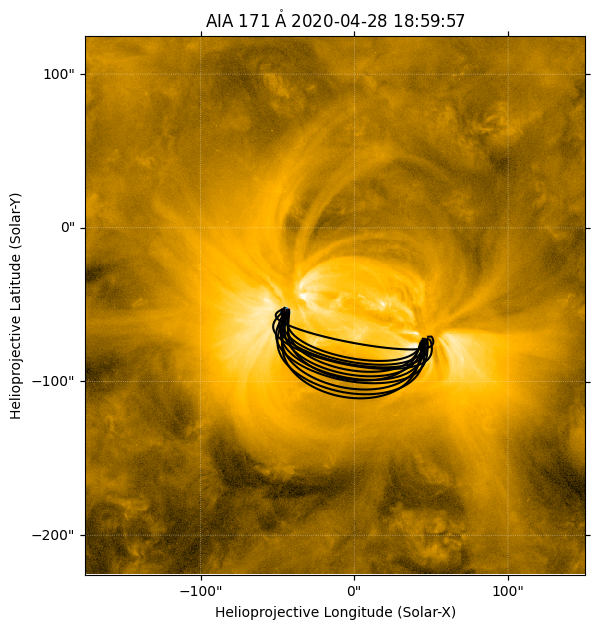

In [35]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection=aia_maps[1])
aia_maps[1].plot(axes=ax)
ax.plot_coord(footprint_center, color='r', marker='x', ls='', )
shapely.plotting.plot_polygon(footprint, ax=ax, add_points=False)
for f in bundle_strands:
    ax.plot_coord(f.coordinate, color='k')

That seems to have a slightly better correspondence with the bright loops in the image.

In [36]:
bundle_skeleton = synthesizAR.Skeleton(bundle_strands)

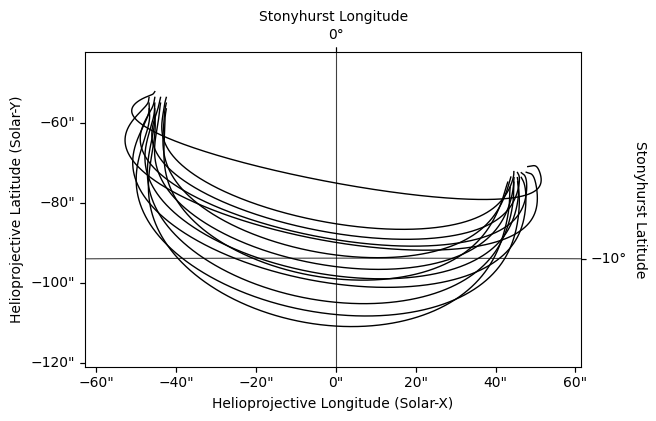

In [37]:
bundle_skeleton.peek(observer=aia_maps[1].observer_coordinate)

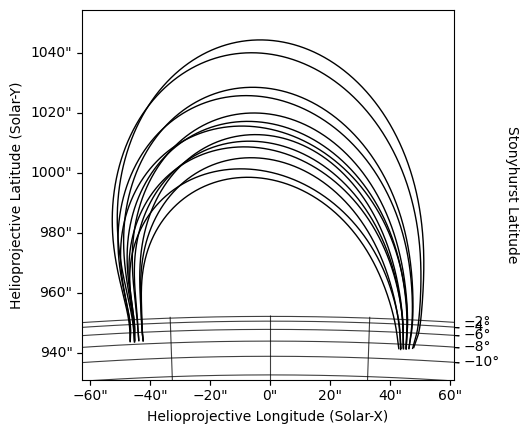

In [45]:
bundle_skeleton.peek(
    observer=SkyCoord(
        lon=aia_maps[1].observer_coordinate.lon,
        lat=-90*u.deg,#aia_maps[1].observer_coordinate.lat-80*u.deg,
        radius=aia_maps[1].observer_coordinate.radius,
        frame=aia_maps[1].observer_coordinate.frame,
    ),
    grid_kwargs={'grid_spacing':2*u.deg},
)

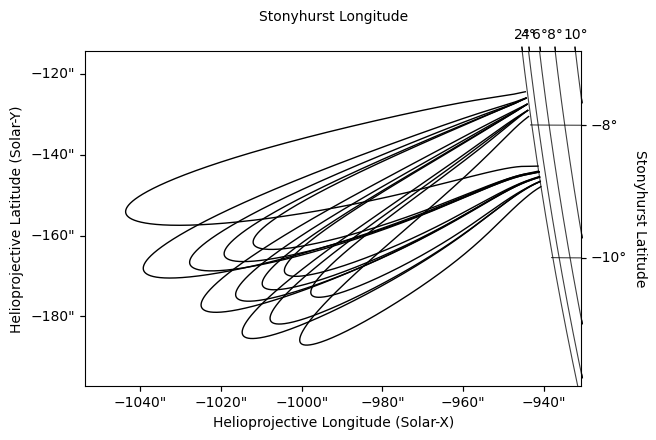

In [53]:
bundle_skeleton.peek(
    observer=SkyCoord(
        lon=aia_maps[1].observer_coordinate.lon+90*u.deg,
        lat=0*u.deg,#aia_maps[1].observer_coordinate.lat-80*u.deg,
        radius=aia_maps[1].observer_coordinate.radius,
        frame=aia_maps[1].observer_coordinate.frame,
    ),
    grid_kwargs={'grid_spacing':2*u.deg},
)

In [47]:
bundle_skeleton.to_asdf('data/bare_bundle_skeleton.asdf')

## HYDRAD Gravitational and Field Profiles

In [80]:
pydrad.configure.util.get_clean_hydrad('data/hydrad-clean', from_github=True, overwrite=True)

In [81]:
!rm -r data/hydrad-clean/Radiation_Model/atomic_data

In [82]:
base_config = pydrad.configure.data.get_defaults()
base_config['general']['poly_fit_gravity'] = {
    'domains': [0,0.25,0.5,0.75,1],
    'order': 6,
}
base_config['general']['poly_fit_magnetic_field'] = {
    'domains': [0,0.25,0.5,0.75,1],
    'order': 6,
}

In [83]:
class NoEvents:
    def calculate_event_properties(self, config, loop):
        config['heating']['background'] = {
            'scale_height': 1e300*u.cm,
            'location': loop.length/2,
            'rate': 1e-6*u.Unit('erg cm-3 s-1'),
        }
        return config

In [84]:
hydrad = HYDRADInterface(
    'data/bundle_hydrad_runs',
    base_config=base_config,
    hydrad_dir='data/hydrad-clean/',
    use_gravity=True,
    use_magnetic_field=True,
    heating_model=NoEvents(),
)

In [86]:
for strand in bundle_skeleton.strands:
    hydrad.configure_input(strand, run_initial_conditions=False)

 1866 | sprintf( szPhysicalFilename, "Results/profile%i.phy", iFileNumber );
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:274:1: note: 'sprintf' has been explicitly marked deprecated here
  274 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
../source/mesh.cpp:1882:1: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 1882 |